# Tweets to 45

Since May of 2017 [Nick Ruest](https://ruebot.net/) of the [Archives Unleashed](https://archivesunleashed.org/) project has been [collecting](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP/8BAVQM) tweets that have been directed to @realDonaldTrump (aka 45). He has been running [twarc](https://github.com/docnow/twarc) from cron every 5 days with the following query:

    % twarc search 'to:realdonaldtrump' 
    
As of February 1, 2019 the dataset is 146,341,720 tweets. In addition to distributing the tweet identifiers Nick made a CSV of the dataset available that looks like:

```csv
"877156113707388928","Tue Jun 20 13:28:08 +0000 2017","ginsengity",false
"877156104928677888","Tue Jun 20 13:28:06 +0000 2017","JBarronPR",false
"877156095441092608","Tue Jun 20 13:28:04 +0000 2017","signthed3al",false
"877156083499925504","Tue Jun 20 13:28:01 +0000 2017","katkel_ga",false
"877156075560067077","Tue Jun 20 13:27:59 +0000 2017","MarieRoff",false
"877156072863256576","Tue Jun 20 13:27:59 +0000 2017","White_GoodmanKD",false
"877156070208274434","Tue Jun 20 13:27:58 +0000 2017","dennis0805a",false
"877156057050742784","Tue Jun 20 13:27:55 +0000 2017","mimzie48",false
```

Let's load this CSV data into a database so we can query it. I tried using SQLite at first for this, but it was *way* too slow. So I have a local instance Postgres running, and have a database called *notebooks* which I'm going to create a table in that I can query:

In [2]:
import psycopg2

db = psycopg2.connect("dbname=notebooks user=edsu")
cursor = db.cursor()

cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS tweets (
        id VARCHAR(25), 
        created TIMESTAMP, 
        screen_name VARCHAR(255), 
        retweet BOOLEAN
    )
    """
)

db.commit()

Now we can read the CSV file that we have already downloaded from https://dx.doi.org/10.5683/SP/8BAVQM and insert it into the database. A progress bar is used because this can take a while.

In [21]:
import csv
import gzip

from tqdm import tqdm
from dateutil.parser import parse

progress = tqdm(desc='loading tweets', total=146341720, unit='tweet')
 
csv_file = '/Users/edsu/Dat/to45/to_realdonaldtrump_20190130_users.csv.gz'

# load in the rows (print a message every 1000000 rows)
for row in csv.reader(gzip.open(csv_file, 'rt')):
    
    # convert the date format
    t = parse(row[1])
    
    # set retweet to 1 or 0 (sqlite doesn't have booleans)
    retweet = row[3] == "true"
    
    cursor.execute(
        'INSERT INTO tweets VALUES (%s, %s, %s, %s)', 
        (row[0], t, row[2], retweet)
    )
    
    progress.update(1)
        
db.commit()
progress.close()

loading tweets: 100%|█████████▉| 146341604/146341720 [12:30:21<00:00, 2862.60tweet/s]  

That probably took *a while*! It'll make our queries run faster if we create a primary key and a couple indexes.

In [25]:
db.commit()
cursor.execute("ALTER TABLE tweets ADD PRIMARY KEY(id)")
cursor.execute("CREATE INDEX IF NOT EXISTS tweets_screen_name ON tweets(screen_name)")
cursor.execute("CREATE INDEX IF NOT EXISTS tweets_retweet ON tweets(retweet)")

In [26]:
db.commit()

Now we are ready to try a query. First, let's see how many tweets there are:

In [27]:
cursor.execute("SELECT COUNT(*) FROM tweets")
print(cursor.fetchone())

(146341720,)


How many of those were not retweets?

In [30]:
cursor.execute("SELECT COUNT(*) FROM tweets WHERE retweet = false")
print(cursor.fetchone())

(107612356,)


How many distinct users have tweeted?

In [29]:
cursor.execute("SELECT COUNT(DISTINCT(screen_name)) FROM tweets")
print(cursor.fetchone())

(9489375,)


Who are the top 100 users that have tweeted directly (not a retweet):

In [3]:
q = """
    SELECT screen_name, COUNT(*) AS total 
    FROM tweets
    WHERE retweet = false
    GROUP BY screen_name
    ORDER BY total DESC
    LIMIT 100
    """
cursor.execute(q)
users = cursor.fetchall()

In [7]:
for screen_name, count in users[0:10]:
    print(screen_name, count)

constitutionB0t 194892
Dookofurl 29919
jinsefoz1 28255
45RAPEDKATIE 28115
TrumpLuvr2000 20413
michaelleves 20149
RomeoIIIV 17330
pagosadude 17247
PaysonMelissa 16598
DanTho864 16038


Yes, it looks like constitutionB0t tweeted at Trump 194,892 times. It also looks like they are now [suspended](https://twitter.com/constitutionB0t). It would be interesting to know how many of these top 100 are suspended.

In [14]:
import requests

def is_suspended(screen_name):
    response = requests.get('https://twitter.com/{}'.format(screen_name))
    if response.url == 'https://twitter.com/account/suspended':
        return True
    return False

print('constitutionB0t', is_suspended('constitutionB0t'))
print('realDonaldTrump', is_suspended('realDonaldTrump')) # I wish!
    

constitutionB0t True
realDonaldTrump False


In [18]:
suspended = 0
for screen_name, count in users:
    if is_suspended(screen_name):
        suspended += 1

print("{} suspended".format(suspended))

16 suspended


What does the tweet activity look like over time? Let's draw a chart. But first we need the tweets per day.

In [21]:
sql = "SELECT DATE_TRUNC('day', created) AS time, COUNT(*) AS tweets FROM tweets GROUP BY 1;"
cursor.execute(sql)

results = cursor.fetchall()

Now put the results in a DataFrame so they can be handed off to [altair](https://altair-viz.github.io/).

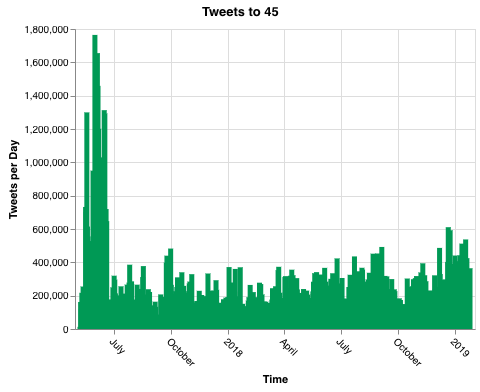

In [35]:
import altair
import pandas

tweets_by_day = pandas.DataFrame(results, columns=['date', 'tweets'])


altair.renderers.enable('notebook')

chart = altair.Chart(tweets_by_day, title="Tweets to 45")
chart = chart.configure_axisX(labelAngle=45)

chart = chart.mark_bar().encode(
    altair.X('date:T', title="Time"),
    altair.Y('tweets', title="Tweets per Day"),
)

chart = chart.configure_mark(color='#095')
chart